#### Final Project Simulation and Modelling

Fabian Kraus: 3032386
Silvia Juzova: 3136278
Louis Lacombe: 3053198
Dimitar Dimitrov: 

In [1]:
import networkx as nx
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
import random
import numpy as np
from scipy.stats import halfnorm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from scipy.integrate import odeint
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 12, 'font.style': 'normal', 'font.family':'serif'})

In [2]:
#Functions to return data for the data collection - computes potential buyers, holders of each stock, prices over time and the rhos. 
#Furthermore it looks at the most connected and least connected notes over time. 

def compute_S(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Susceptible'])

def compute_H(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Holder'])

def compute_H_B(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Holder' and a.stock_amount[0] >0])

def compute_H_E(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Holder' and a.stock_amount[1] >0])

def compute_H_Both(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Holder' and a.stock_amount[1] >0 and a.stock_amount[0] >0])


def compute_H_T(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Holder' and a.stock_amount[1] >0]) + sum([1 for a in model.schedule.agents if a.state == 'Holder' and a.stock_amount[0] >0])

def compute_demand_b(model):
    return model.demand_bitcoin

def compute_demand_e(model):
    return model.demand_ethereum


def compute_price_b(model):
    return model.price_modelled_b_t

def compute_price_e(model):
    return model.price_modelled_e_t


def return_b_most_connected(model):
    chosen_agent=[agent for agent in model.grid.get_cell_list_contents([model.least_connected])][0]
    return chosen_agent.probab_b

def return_b_least_connected(model):
    chosen_agent=[agent for agent in model.grid.get_cell_list_contents([model.most_connected])][0]
    return chosen_agent.probab_b

def return_e_most_connected(model):
    chosen_agent=[agent for agent in model.grid.get_cell_list_contents([model.least_connected])][0]
    return chosen_agent.probab_e

def return_e_least_connected(model):
    chosen_agent=[agent for agent in model.grid.get_cell_list_contents([model.most_connected])][0]
    return chosen_agent.probab_e



In [3]:
prices = pd.read_csv("Data/Historical_prices.csv")
prices["Date"] = pd.to_datetime(prices['Date'])
prices = prices.loc[prices['Date'].dt.year >= 2017][90:].reset_index(drop = True)

In [4]:
#Aggregate Level class 

class Herding_nx(Model):
    """A virus model with some number of agents"""

    def __init__(self, agents, prob, transfer_entropyBE, transfer_entropyEB, rho_b, rho_e, price_b,price_e,
                 initial_holders_size_b=1,initial_holders_size_e=1,max_iter = 500,sensitivity = False,graph = "Erdos",drop_260 = None,max_alpha = 0.9):
        # count number of iterations
        self.ite=1
        self.sensitivity = sensitivity
        # max iteration to perfrom
        self.max_iter=max_iter
        #the first step function:
        self.first=True
        # transfer entropy from bitcoin to ethereum
        self.TE_BE=transfer_entropyBE
        # transfer entropy from ethereum to bitcoin
        self.TE_EB=transfer_entropyEB
        #the rho for calibration error estimation
        self.rho_b=rho_b
        self.rho_e=rho_e
        # define the grap in use
        if graph == "Erdos":
            self.G = nx.erdos_renyi_graph(n = agents, p = prob,seed = 42)
        elif graph == "Barbasi":
            self.G = nx.generators.random_graphs.barabasi_albert_graph(n = agents, m =10,seed = 42)
        elif graph == "Watts":
            self.G = nx.watts_strogatz_graph(n = agents, k=10, p=0.035,seed = 42)

        #population size
        self.population = len(self.G.nodes())
        # define a network grid of mesa to be of structure of random graph, where each node contains zero or more agents.
        self.grid = NetworkGrid(self.G)
        
        self.drop=drop_260
        
        #define the base for modelled prices bitcoin
        self.price_modelled_b_t=price_b[0]
        # define the base for modelled prices ethereum
        self.price_modelled_e_t=price_e[0]
        
        #track simulated price increases
        self.model_price_increase_e=0
        self.model_price_increase_b=0        
        
        #define the base for modelled prices bitcoin
        self.rho_true_b=0
        # define the base for modelled prices ethereum
        self.rho_true_e=0
        
        #for tracking the demand
        self.demand_bitcoin=0
        self.demand_ethereum=0
        
        #activate agents randomly one after another
        self.schedule = RandomActivation(self) 
        #initial number of people holding stocks
        self.initial_holders_size = [initial_holders_size_b,initial_holders_size_e]
        # set of alphas for all agents to be drawn from truncated half normal
        self.max_alpha = max_alpha
        self.alpha_b=np.random.uniform(low = 0.2,high = self.max_alpha,size=self.population)
        #(loc=0,scale=1, )
        #self.alpha_b=halfnorm.rvs(loc=0.001, scale=1, size=self.population) #make sure that each value is bigger than 0
        #self.alpha_e=np.random.normal(loc=0,scale=1, size=self.population)
        self.alpha_e=np.random.uniform(low = 0.2,high = self.max_alpha,size=self.population)
        #self.alpha_e=halfnorm.rvs(loc=0.001, scale=1, size=self.population)
        
          
        """A DataCollector is instantiated with dictionaries of names of model- and
        agent-level variables to collect, associated with attribute names or
        functions which actually collect them. When the collect(...) method is
        called, it collects these attributes and executes these functions one by
        one and stores the results."""
        
        self.datacollector = DataCollector(
        {       'Holder': compute_H,
                'Susceptible': compute_S,
                'Holder_B':compute_H_B,
                'Num_stocks_circulation':compute_H_T,
                'Holder_E':compute_H_E,
                'Holder_both':compute_H_Both,
                'Track_demand_B': compute_demand_b,
                'Track_demand_E': compute_demand_e,
                'Track_price_B': compute_price_b,
                'Track_price_E': compute_price_e,
                'Track_most_connected_b':return_b_most_connected,
                'Track_most_connected_e':return_e_most_connected,
                'Track_least_connected_b':return_b_least_connected,
                'Track_least_connected_e':return_e_least_connected
         
            }
        )
        
        
        # INITIALIZATION OF OUR POPULATION:
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = SHAgent_nx(i,self)
            # add into random activation of agents
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)
        
        def initiate_holders(size,pos):
            holders_nodes = self.random.sample(self.G.nodes(), size)
            for a in self.grid.get_cell_list_contents(holders_nodes):
                a.state = 'Holder'
                a.stock_amount[pos]=1
                

        # make some people hold bitcoin at random
        initiate_holders(self.initial_holders_size[0],0)
        # make some people hold ethereum at random
        initiate_holders(self.initial_holders_size[1],1)
        
        
        
        self.most_connected=np.argmax([len(self.grid.get_neighbors(agent.pos, include_center=False)) 
         for agent in self.grid.get_cell_list_contents(np.arange(self.population))])
        
        self.least_connected=np.argmin([len(self.grid.get_neighbors(agent.pos, include_center=False)) 
         for agent in self.grid.get_cell_list_contents(np.arange(self.population))])
        
        #start running the algorithm, count for the first time
        self.running = True
        self.datacollector.collect(self)
        
        
    def return_amount_to_buy(self,old,new):         
        # each agent is willing to pay at max the price of the previous day
        #if the price is lower today: buy 1 stock
        if old > new: 
            return 1;
        return old/new        
 

    

         
    def step(self):
        if self.first:
            #keep count of number of people interested in buying/selling each stock
            self.want_buy_bitcoin, self.want_buy_ethereum=np.zeros(self.population), np.zeros(self.population) 
            self.want_sell_bitcoin, self.want_sell_ethereum=np.zeros(self.population), np.zeros(self.population) 
            

            # initiate the step of all agents
            self.schedule.step()
            #determine the overall market demand for the two stocks
            self.demand_bitcoin=np.sum(self.want_buy_bitcoin)-np.sum(self.want_sell_bitcoin)
            self.demand_ethereum=np.sum(self.want_buy_ethereum)-np.sum(self.want_sell_ethereum)
            
            #print(self.price_modelled_b_t,self.demand_bitcoin)

            #calculate the simulated price
            old_price_b=self.price_modelled_b_t.copy()
            self.price_modelled_b_t=self.price_modelled_b_t*(np.exp(self.rho_b*self.demand_bitcoin))#+np.random.normal
            

            self.model_price_increase_b= self.price_modelled_b_t/old_price_b-1
            
            #calculate the simulated price
            old_price_e=self.price_modelled_e_t.copy()
            self.price_modelled_e_t=self.price_modelled_e_t*(np.exp(self.rho_e*self.demand_ethereum))#+np.random.normal
            

            self.model_price_increase_e= self.price_modelled_e_t/old_price_e-1
            
            #define how many stocks will each interested agent buy
            self.amount_buy_b=self.return_amount_to_buy(old_price_b,self.price_modelled_b_t)
            self.amount_buy_e=self.return_amount_to_buy(old_price_e,self.price_modelled_e_t)
           
 
            self.first=False

            
        #the second step function:       
        else:
            # initiate the step of all agents
            self.schedule.step()

               
            # collect data    
            self.datacollector.collect(self)
        
            #if no more people interested in buying or we exceed the running treshold stop running 
            if compute_S(self) == 0 or self.ite>=self.max_iter:  
                self.running = False
            
            #For sensitivity tests of alpha only
            if self.sensitivity:
                if self.ite == 260:
                    self.alpha_b = self.alpha_b*self.drop
                    self.alpha_e = self.alpha_e*self.drop

              
            #Shocks introduced to alpha
            else:
                if self.ite == 260:
                    self.alpha_b = self.alpha_b * 0.9
                if self.ite == 305:
                    self.alpha_b = self.alpha_b * 0.8
                    self.alpha_e = self.alpha_e * (2/3)

                if self.ite == 350:
                    self.alpha_b = self.alpha_b * 1.3
                    self.alpha_e =  self.alpha_e * 1.3

                if self.ite == 450:
                    self.alpha_b = self.alpha_b * 0.95
                    self.alpha_e = self.alpha_e * 0.95
                
            self.ite+=1
            self.first=True




In [6]:
#Agent level class
class SHAgent_nx(Agent):
    def __init__(
        self,
        unique_id,
        model):
        super().__init__(unique_id, model)
        # Set the initial state for all agents to be suspectible thus hold no stocks
        self.state = 'Susceptible'
        self.stock_amount=[0,0]
        self.id=unique_id
        #map agents interest in selling/buying the cryptos
        self.want_sell=[0,0]
        self.want_buy=[0,0]
        self.probab_b=0
        self.probab_e=0
        
        
    def normalize(self, probab):
        return np.exp(probab)/(1+np.exp(probab))
        
    
    def probability_to_buy(self):
        # get all the neighbours for the given agent and calculate percentage of neighbours holding bitcoin or ethereum
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        num_neighbors=len(neighbors_nodes)
        #nj
        n_bitcoin=len([agent.stock_amount[0] 
                                    for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
                      if agent.stock_amount[0]>0])/num_neighbors
        #nl
        n_ethereum=len([agent.stock_amount[1] 
                                    for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
                       if agent.stock_amount[1]>0])/num_neighbors
        
        
        lamda_b= compute_H_B(self.model)/self.model.population
        lambda_e=compute_H_E(self.model)/self.model.population
        
        #create a probability for every individual to buy a bitcoin
        p_buy_bitcoin=(self.model.alpha_b[self.id]+(n_bitcoin*lamda_b + self.model.TE_EB*n_ethereum*lambda_e))/(self.model.max_alpha + 1  + self.model.TE_EB) 
        #p_buy_bitcoin=self.normalize(p_buy_bitcoin)
        

        p_buy_ethereum=(self.model.alpha_e[self.id]+(n_ethereum*lambda_e + self.model.TE_BE*n_bitcoin*lamda_b))/(self.model.max_alpha + 1+  self.model.TE_BE) 
        
        
        self.probab_b=p_buy_bitcoin
        self.probab_e=p_buy_ethereum
        
        return p_buy_bitcoin, p_buy_ethereum
        
        
    
    def make_transactions(self,stock,amount_buy,interested_sellers):
        #calculate aggregate supply
        want_sell=np.sum(interested_sellers)
        if self.want_buy[stock]>0 and want_sell>0.000000001:
            buy=np.minimum(amount_buy,want_sell)
            total_bought=0  
            # iterate until the agent obtain the sufficient amount of stock he wants or until all stocks are sold
            while total_bought<buy and want_sell>0.000000001:
                

                #choose a random seller out of those who sell
                sellers=np.argwhere(interested_sellers)
                chosen_seller_id=random.choice(sellers)[0]
                # extract the amount the seller is willing to sell 
                chosen_seller=[agent for agent in self.model.grid.get_cell_list_contents([chosen_seller_id])][0]
                seller_value=chosen_seller.stock_amount[stock]
                #buy from the agent either all his possesion, or part of the possesion if we want less that the total value owned
                bought=np.minimum(seller_value, buy-total_bought)
                #substract the amount bought from the seller
                chosen_seller.stock_amount[stock]-=bought
                if np.sum(chosen_seller.stock_amount)==0:
                    chosen_seller.state='Susceptible'
                #increase the number of bought by an agent
                total_bought+=bought
                #decrease the aggregate supply of stocks
                want_sell-=bought
                #decrease by the amount bought the sellers account
                interested_sellers[chosen_seller_id]-=bought
                self.stock_amount[stock]+=bought
                
                   
            #assignt to the buyer amount that he bought
            self.state='Holder'
        #make the person switch to group, which is not interested in buying
        self.want_buy[stock]=0
            

    def step(self):
    
        
        # for the first iteration through agents to get number of people interested in buying or selling
        if self.model.first:   
            self.want_sell=[0,0]
            self.want_buy=[0,0]
            p_buy_bitcoin, p_buy_ethereum=self.probability_to_buy()


            #non bitcoin holders who are interested
            if  self.stock_amount[0] == 0:
                # draw agent decision about each stock
                action_bitcoin=np.random.binomial(1, np.minimum(p_buy_bitcoin, 1))
                
                
                #add his decision for demand calculation
                self.model.want_buy_bitcoin[self.id]=action_bitcoin
                                
                #update his desired actions 
                self.want_buy[0]=action_bitcoin
                
            # non ethereum holders, same as above    
            if  self.stock_amount[1] == 0:    
                action_ethereum=np.random.binomial(1,np.minimum(p_buy_ethereum,1))
                
                self.model.want_buy_ethereum[self.id]=action_ethereum
                
                self.want_buy[1]=action_ethereum
                
            # bitcoin holder    
            if  self.stock_amount[0] > 0:  
                
                # draw agent decision about the stock and if he sells, he sells proportionally to what he currently owns
                action_bitcoin=np.random.binomial(1, np.minimum(np.maximum(1-p_buy_bitcoin +self.model.model_price_increase_b, 0.01),1))*self.stock_amount[0]
                
                #add his decision for demand calculation into array holding all decisions of agents
                self.model.want_sell_bitcoin[self.id]=action_bitcoin
                
                #update his desired actions
                self.want_sell[0]=action_bitcoin
                
            #ethereum holder, same as above
            if  self.stock_amount[1] > 0:
                action_ethereum=np.random.binomial(1,np.minimum(np.maximum(1-p_buy_ethereum+self.model.model_price_increase_e,0.01),1))*self.stock_amount[1]
            
                self.model.want_sell_ethereum[self.id]=action_ethereum          
                
                self.want_sell[1]=action_ethereum
        # for the second run to execute transactions
        else:
           
            if self.want_buy[0]>0:
                self.make_transactions(stock=0, #bitcoin
                                   amount_buy=self.model.amount_buy_b, #how much each agent wants to buy
                                   interested_sellers=self.model.want_sell_bitcoin) #total number of bitcoin available sellers
            if self.want_buy[1]>0:
                self.make_transactions(stock=1,
                                   amount_buy=self.model.amount_buy_e,
                                   interested_sellers=self.model.want_sell_ethereum)

            


### Calibration

In [6]:
#MSE calibration 

for_calibration = prices.loc[prices["Date"] <= "2018-01-31"]

import itertools as it

def MSE_calibration(model,parameters,true_data,n_runs = 20):
    #get all the combinations of parameters
    combinations = it.product(*(parameters[Name] for Name in parameters))
    
    MSEs = []
    y_hats = []
    for combi in combinations:
        keys = parameters.keys()
        curr_params = dict(zip(keys,combi))
        print(curr_params)
        curr_params["price_b"] = for_calibration["Bitcoin"]
        curr_params["price_e"] = for_calibration["Ethereum"]
        
        #simulate the model n_runs times
        mse_Runs = []
        y_hats_runs = []
        for i in range(n_runs):
            #set model with current parameters and execute
            RES = model(**curr_params)

            for i in range(len(true_data)*2-2):
                RES.step()
            
            #retrieve price data and compute the MSE
            data = RES.datacollector.get_model_vars_dataframe()
            price_B = data["Track_price_B"]
            price_E = data["Track_price_E"]

            new_MSE_B = np.sqrt(np.sum((price_B.values - true_data["Bitcoin"].values)**2)/(len(true_data)))
            new_MSE_E = np.sqrt(np.sum((price_E.values - true_data["Ethereum"].values)**2)/(len(true_data)))
            mse_Runs.append([new_MSE_B,new_MSE_E])
            y_hats_runs.append([price_B.values,price_E.values])
            
        #get the mean mse and y_hats of the n_runs and append
        mean_MSEs = np.mean(mse_Runs,axis = 0)
        mean_y_hats = np.mean(y_hats_runs,axis = 0)
        print(mean_MSEs[0],mean_MSEs[1])
        
        MSEs.append([mean_MSEs[0],mean_MSEs[1]])
        y_hats.append(mean_y_hats)
    return MSEs,y_hats



In [ ]:
rho_b = np.arange(0.0008,0.0011,0.0001)
rho_e = np.arange(0.0005,0.0008,0.0001)
for_calibration = for_calibration.loc[:for_calibration["Bitcoin"].argmax()]

parameters = {"agents": [500],
              "prob": [0.03],
              "rho_b": rho_b,
              "rho_e":rho_e,
              "initial_holders_size_b" : [140],
              "initial_holders_size_e" : [140],
              "transfer_entropyEB" : [0.2316446679708485],
              "transfer_entropyBE" : [0.14685819150949184]
}

"""
Takes a lot of time to run the calibration
"""
mses, y_hats = MSE_calibration(Herding_nx,parameters,for_calibration,n_runs = 30)

{'agents': 500, 'prob': 0.03, 'rho_b': 0.0008, 'rho_e': 0.0005, 'initial_holders_size_b': 140, 'initial_holders_size_e': 140, 'transfer_entropyEB': 0.2316446679708485, 'transfer_entropyBE': 0.14685819150949184}
2119.2935663497274 133.55532466226546
{'agents': 500, 'prob': 0.03, 'rho_b': 0.0008, 'rho_e': 0.0006000000000000001, 'initial_holders_size_b': 140, 'initial_holders_size_e': 140, 'transfer_entropyEB': 0.2316446679708485, 'transfer_entropyBE': 0.14685819150949184}


In [ ]:
#Get the best model of all the different runs - best_index, params and mses

rhos = np.array(list(it.product(*(parameters[Name] for Name in parameters))))[:,2:4]

mses = np.array(mses)
best_bitcoin = mses[:,0].argmin()
rhos_ethereum_index = np.where(rhos[:,0] == rhos[best_bitcoin,0])[0]

best_index =rhos_ethereum_index[mses[rhos_ethereum_index,1].argmin()]

best_params = rhos[best_index]
best_params


In [ ]:
fig, axs = plt.subplots(1,2, facecolor='w', figsize=(13,4))
axs[0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_params[0], 5), round(mses[best_index,0],2)))
axs[0].scatter(np.arange(len(for_calibration["Bitcoin"])), for_calibration["Bitcoin"], color = 'b', label = 'I_data')
axs[0].plot(np.arange(len(for_calibration)) ,y_hats[best_index][0], alpha=1, lw=2, label='I_daily', color = 'darkred')
axs[0].set_xlabel("Time")
axs[0].set_ylabel('Cases')


axs[1].set_title('Models Tested')
axs[1].plot(np.arange(len(for_calibration)), y_hats[0][0], alpha=0.5,  color = 'k', lw=1, label ='models tested' )
for rh, I in zip(rhos, y_hats):
    if rh[0] == rhos[best_index,0] and rh[1] == rhos[best_index,1]:
        
        axs[1].plot(np.arange(len(for_calibration)), I[0], c = 'darkred', lw=5, label = 'best model')
    else:
        axs[1].plot(np.arange(len(for_calibration)), I[0], alpha=0.05,  color = 'k', lw=1)
axs[1].set_xlabel("Time")
axs[1].set_ylim(0,4e4)
axs[1].set_ylabel('Cases')



for i in range(2):
    axs[i].legend(fancybox = True)
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)
        
fig.tight_layout()
plt.savefig("Images/Calibration_Bitcoin.png",dpi = 400)

In [ ]:
fig, axs = plt.subplots(1,2, facecolor='w', figsize=(13,4))
axs[0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_params[1], 5), round(mses[best_index,0],2)))
axs[0].scatter(np.arange(len(for_calibration)), for_calibration["Ethereum"], color = 'b', label = 'I_data')
axs[0].plot(np.arange(len(for_calibration)) ,y_hats[best_index][1], alpha=1, lw=2, label='I_daily', color = 'darkred')
axs[0].set_xlabel("Time")
axs[0].set_ylabel('Cases')


axs[1].set_title('Models Tested')
axs[1].plot(np.arange(len(for_calibration)), y_hats[0][1], alpha=0.5,  color = 'k', lw=1, label ='models tested' )
for rh, I in zip(rhos, y_hats):
    if rh[0] == rhos[best_index,0] and rh[1] == rhos[best_index,1]:
        
        axs[1].plot(np.arange(len(for_calibration)), I[1], c = 'darkred', lw=5, label = 'best model')
    else:
        axs[1].plot(np.arange(len(for_calibration)), I[1], alpha=0.05,  color = 'k', lw=1)
axs[1].set_xlabel("Time")
axs[1].set_ylim(0,5e3)
axs[1].set_ylabel('Cases')



for i in range(2):
    axs[i].legend(fancybox = True)
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)
        
fig.tight_layout()
plt.savefig("Images/Calibration_Ethereum.png",dpi = 400)

### Sensitivity Analysis

In [7]:
transfer_entropyBE = 0.14685819150949184
transfer_entropyEB = 0.2316446679708485
agents = 500
prob = 0.035
rho_b = 0.0009
rho_e = 0.0006

initial_holders_size_b = 140
initial_holders_size_e = 140
n_simulations = 20

In [8]:
#Function to run model over n_simulations
def run_simulations(n_runs,t = 500,sensitivity = False,graph = "Erdos",shock = None):
    #loop through simulation and call model for t steps
    results_list = []
    for i in range(n_runs):
        model = Herding_nx(agents, prob ,transfer_entropyBE, transfer_entropyEB, rho_b, rho_e, prices["Bitcoin"],prices["Ethereum"],initial_holders_size_b,initial_holders_size_e,sensitivity = sensitivity,graph = graph,drop_260 = shock)

        for i in range(t*2-2):
            model.step()
        data = model.datacollector.get_model_vars_dataframe()
        results_list.append(data.values)
        print(data["Track_price_B"].iloc[-1],data["Track_price_E"].iloc[-1])
    
    cols = model.datacollector.get_model_vars_dataframe().columns
    return results_list,cols

In [9]:
#run model for different changes in alpha at 260 - in this case changes increasing the individual propensity to buy
results_list = []
drop = [1, 1.1, 1.2, 1.4]
for shock in drop:
    results,cols = run_simulations(20,350,sensitivity = True,shock = shock)
    results_list = results_list + results

<ipython-input-4-de678d3d5dad>:105: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  holders_nodes = self.random.sample(self.G.nodes(), size)


13866.55027470307 2320.4590622188775
24537.558171367553 969.2122992723403
18334.31011785775 2018.5534809446963
63608.39805118467 1627.7332274181722
37544.97240701108 1708.995926016256
7442.778630522665 334.45156976131165
55003.52974077292 1527.7995023999058
53655.19669899568 1410.3142176688923
22414.69742735647 1899.872102669203
11507.102190192632 1497.8995361513278
11469.981550188928 1308.735230443645
31496.17693597552 2110.5346446178896
86142.59465789537 996.262070417492
15573.102651464911 1180.4927253809453
17225.55145550615 2272.1628706035312
22492.73249309979 1310.9506247247532
57085.178581840555 1484.505100299975
33935.0970093731 1456.715155638616
33295.28790154581 1466.862157891073
59365.24513048853 1454.235107702728
52859.4061786211 1875.0811061013221
34750.85228152878 2096.374033057549
58881.81733017654 3235.602639633599
254043.06844663425 1107.071971405289
34659.41578557384 2751.8432484414425
87160.92812971777 1074.7307023616881
124454.40069023127 2342.8083662299755
68874.345

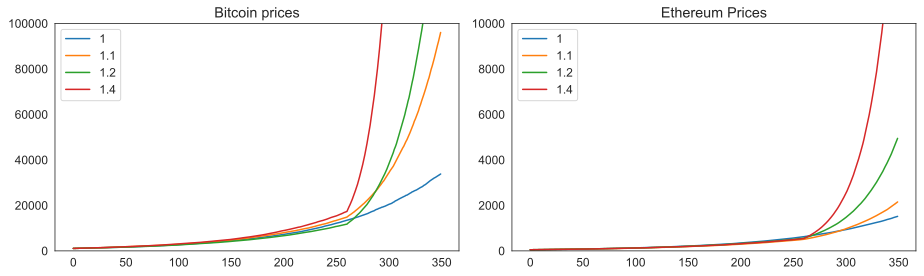

In [10]:
#Plot the prices over the for sensitivities
sns.set_style("white")
fig, axs = plt.subplots(1,2,figsize = (13,4))
keeper = []
for i,result in enumerate(results_list):
    keeper.append(result)
    if (i+1)%20 == 0:
        mean_result = np.mean(keeper,axis = 0)
        keeper = []
        axs[0].plot(np.arange(len(mean_result)),mean_result[:,8],label = drop[int((i+1)/20)-1])
        axs[0].set_title("Bitcoin prices")
        axs[0].set_ylim(0,1e5)
        axs[0].legend()
        axs[1].plot(np.arange(len(mean_result)),mean_result[:,9],label = drop[int((i+1)/20)-1])
        axs[1].set_title("Ethereum Prices")
        axs[1].set_ylim(0,1e4)
        axs[1].legend()

fig.tight_layout()
plt.savefig("Images/Sensitivity_to_alpha.png",dpi = 400)

In [29]:
#run model for different changes in alpha at 260 - in this case changes decrease the individual propensity to buy
results_list = []
drop = [1, 0.9, 0.8, 0.6]
for shock in drop:
    results,cols = run_simulations(20,350,sensitivity = True,shock = shock)
    results_list = results_list + results

28713.12810543715 3353.0893283944247
46139.33139411775 922.4854574348525
32284.233919040224 701.9992394087562
12175.62830980675 1238.5064223527397
22730.483911500178 766.501624446082
28035.12675631121 965.7151578769192
12573.709345876907 1115.0115115047154
17790.794343095717 1568.243477814552
13756.146261620815 472.95231296141355
13465.795658902181 442.694637327111
31996.394478166927 1244.3357557647857
12520.221044704755 1676.1532184145908
31698.312363278637 1582.767574644255
22247.05871352623 1118.5857221956899
17243.830982934407 1711.01514639139
26673.066191740774 1387.7210216284418
22634.189701556792 1352.6866408944436
7036.236136301634 1173.3463874429508
17283.419052324403 1338.1362514139182
15141.363307178051 679.0833104844626
8316.286123727798 418.3372877273868
8053.238358606049 641.75191532611
7060.660062434241 875.3035657182
8009.08193382867 587.7879486762355
6830.129903832461 771.1794120852289
7787.46018158635 296.3286078546466
24066.951240670012 754.648488862567
3187.07196886

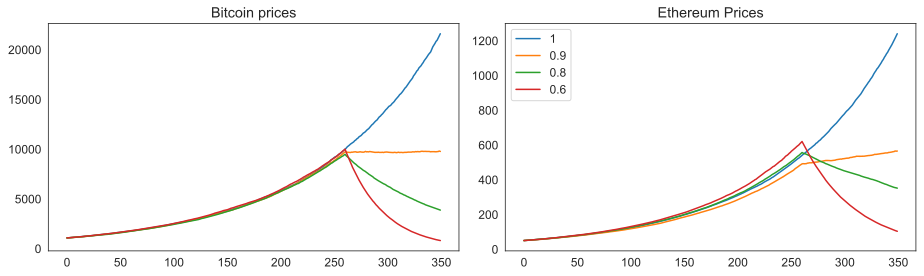

In [30]:
#Plot the prices over the for sensitivities

fig, axs = plt.subplots(1,2,figsize = (13,4))
keeper = []
for i,result in enumerate(results_list):
    keeper.append(result)
    if (i+1)%20 == 0:
        mean_result = np.mean(keeper,axis = 0)
        keeper = []
        axs[0].plot(np.arange(len(mean_result)),mean_result[:,8],label = drop[int((i+1)/20)-1])
        axs[0].set_title("Bitcoin prices")
        
        axs[1].plot(np.arange(len(mean_result)),mean_result[:,9],label = drop[int((i+1)/20)-1])
        axs[1].set_title("Ethereum Prices")

fig.tight_layout()
plt.legend()

plt.savefig("Images/Sensitivity_to_alpha_down.png",dpi = 400)

### Introducing shocks into the market


In [62]:
results_list, cols = run_simulations(20)

mean_result = np.mean(results_list,axis = 0)
median_result = np.median(results_list,axis = 0)

df_means = pd.DataFrame(mean_result,columns=cols)

5209.020399590693 238.35844323072956
9399.615923998266 1503.2957176207651
752.7367509384247 240.21989056935323
17203.491862503026 342.58327944453356
1063.0832320049244 174.13064591384125


In [58]:
std_result = np.std(results_list,axis = 0)


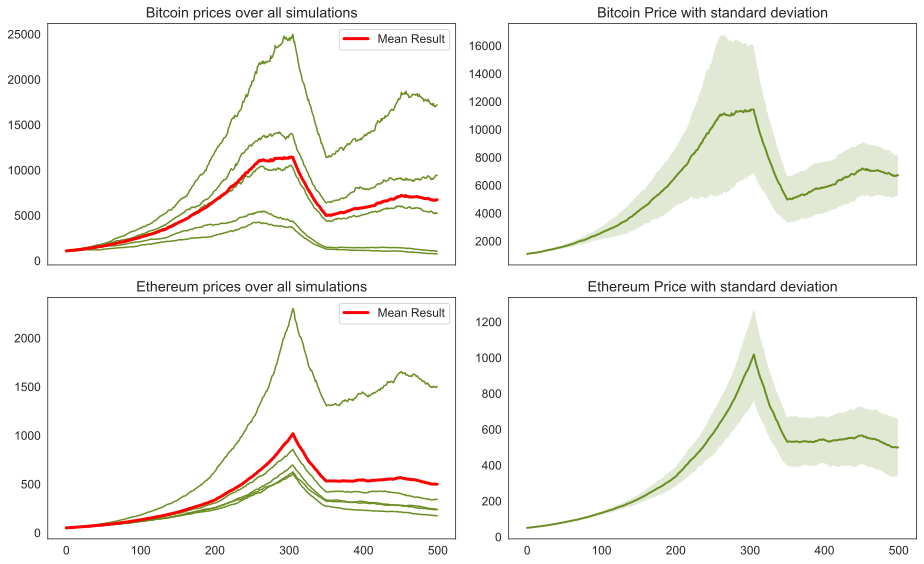

In [63]:
sns.set_style("white")
fig,axs = plt.subplots(2,2,figsize = (13,8))
t = np.arange(len(results_list[0]))

ax = axs[0][0]
ax.set_title("Bitcoin prices over all simulations")
for result in results_list:
    
    ax.plot(t,result[:,8],color = "olivedrab")
ax.plot(t,df_means["Track_price_B"],color = "r",label = "Mean Result",linewidth = 3)
ax.set_xticks([])
ax.legend(fancybox = True)
ax.set_ylim(0,25000)

ax = axs[0][1]
ax.set_title('Bitcoin Price with standard deviation')
ax.plot(t, df_means["Track_price_B"], c = 'olivedrab', lw=2, label = 'mean S')
ax.fill_between(t, df_means["Track_price_B"]+std_result[:,8], df_means["Track_price_B"]-std_result[:,8], facecolor='olivedrab', alpha=0.2)
#ax.legend(fancybox = True)
ax.set_xticks([])

ax = axs[1][0]
ax.set_title("Ethereum prices over all simulations")
for result in results_list:
    
    ax.plot(t,result[:,9],color = "olivedrab")
ax.plot(t,df_means["Track_price_E"],color = "red",label = "Mean Result",linewidth = 3)
ax.legend(fancybox = True)

ax = axs[1][1]
ax.set_title('Ethereum Price with standard deviation')
ax.plot(t, df_means["Track_price_E"], c = 'olivedrab', lw=2, label = 'mean S')
ax.fill_between(t, df_means["Track_price_E"]+std_result[:,9], df_means["Track_price_E"]-std_result[:,9], facecolor='olivedrab', alpha=0.2)
#ax.legend(fancybox = True)
ax.set_ylim(0,1500)

fig.tight_layout()

plt.savefig("Images/Shocks_Prices.png",dpi = 400)

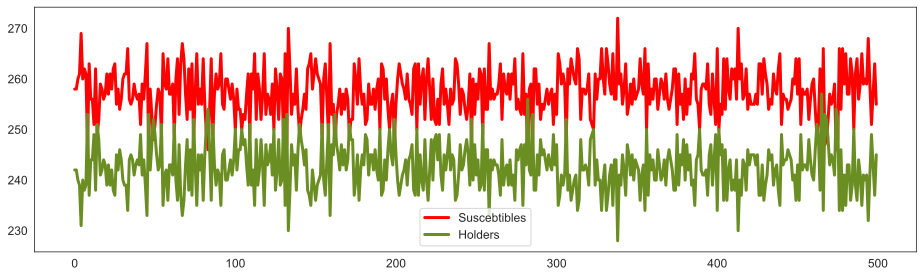

In [83]:
#Plots holders of both coins 

fig,axs = plt.subplots(1,1,figsize = (13,4))
ax = axs


ax.plot(t,results_list[0][:,1],color = "r",label = "Suscebtibles",linewidth = 3)
ax.plot(t,results_list[0][:,0],color = "olivedrab",label = "Holders",linewidth = 3)
ax.legend(fancybox = True)

 

fig.tight_layout()
plt.savefig("Images/Shocks_Coin_Holders.png",dpi = 400)

### Understanding Different Network Effects


In [ ]:
results_list_Barbasi, cols = run_simulations(20,graph = "Barbasi")

mean_result_Barbasi = np.mean(results_list,axis = 0)
median_result_Barbasi = np.median(results_list,axis = 0)

df_means_Barbasi = pd.DataFrame(mean_result_Barbasi,columns=cols)

In [ ]:
results_list_Watts, cols = run_simulations(20,graph = "Watts")

mean_result_Watts = np.mean(results_list,axis = 0)
median_result_Watts = np.median(results_list,axis = 0)

df_means_Watts = pd.DataFrame(mean_result_Watts,columns=cols)

In [ ]:
sns.set_style("white")
fig,axs = plt.subplots(2,2,figsize = (12,10))
t = np.arange(len(df_means))

ax1 = axs[0][0]
ax1.plot(t,df_means['Track_most_connected_b'],color = "olivedrab")
ax1.plot(t,df_means_Barbasi['Track_most_connected_b'],color = "mediumblue")
ax1.plot(t,df_means_Watts['Track_most_connected_b'],color = "darkorange")
ax1.set_ylim([0.18, 0.40])

ax2 = axs[0][1]
ax2.plot(t,df_means['Track_least_connected_b'],color = "olivedrab")
ax2.plot(t,df_means_Barbasi['Track_least_connected_b'],color = "mediumblue")
ax2.plot(t,df_means_Watts['Track_least_connected_b'],color = "darkorange")
ax2.set_ylim([0.18, 0.40])


ax3 = axs[1][0]
ax3.plot(t,df_means['Track_most_connected_e'],color = "olivedrab")
ax3.plot(t,df_means_Barbasi['Track_most_connected_e'],color = "mediumblue")
ax3.plot(t,df_means_Watts['Track_most_connected_e'],color = "darkorange")
ax3.set_ylim([0.18, 0.40])

ax4 = axs[1][1]
ax4.plot(t,df_means['Track_least_connected_e'],color = "olivedrab")
ax4.plot(t,df_means_Barbasi['Track_least_connected_e'],color = "mediumblue")
ax4.plot(t,df_means_Watts['Track_least_connected_e'],color = "darkorange")
ax4.set_ylim([0.18, 0.40])

plt.legend(["Erdos", "Barbasi", "Watts"], bbox_to_anchor=(1.05, 1), loc='lower left')
fig.tight_layout()

plt.savefig("Images/Different_Networks.png",dpi = 400)

In [ ]:
std_most_connected = np.std(df_means_Barbasi['Track_most_connected_b'].values)
std_least_connected = np.std(df_means_Barbasi['Track_least_connected_b'].values)
difference = (std_most_connected-std_least_connected)/std_least_connected
print(f"std_dev_most {std_most_connected}")
print("-"*30)
print(f"std_dev_least {std_least_connected}")
print("-"*30)
print(f"probability {proba}")


### Full Simulation of a model using Mesas interactive environment

When using this, the model will be sensitive to stochasticity and hence may not accurately depict the results. 

In [22]:
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
#from model_sir_nx import VirusOnNetwork


def network_portrayal(G):
    # The model ensures there is always 1 agent per node
    def node_color(agent):
        return {'Holder': '#FF0000', 'Susceptible': '#008000'}.get(agent.state, '#808080')

    def edge_color(agent1, agent2):
        if 'Holder' in (agent1.state, agent2.state):
            return '#000000'
        return '#e8e8e8'

    def edge_width(agent1, agent2):
        if 'Holder' in (agent1.state, agent2.state):
            return 3
        return 2

    def get_agents(source, target):
        return G.nodes[source]['agent'][0], G.nodes[target]['agent'][0]

    portrayal = dict()
    portrayal['nodes'] = [{'size': 6,
                           'color': node_color(agents[0]),
                           }
                          for (_, agents) in G.nodes.data('agent')]

    portrayal['edges'] = [{'source': source, #from
                           'target': target, #to
                           'color': edge_color(*get_agents(source, target)),
                           'width': edge_width(*get_agents(source, target)),
                           }
                          for (source, target) in G.edges]
    return portrayal


network = NetworkModule(network_portrayal, 500, 500, library='d3')
chart = ChartModule([{'Label': 'Susceptible', 'Color': '#FF0000'},
                     {'Label': 'Holder', 'Color': '#008000'}])
chart1 = ChartModule([{'Label':'Num_stocks_circulation', 'Color': '#808080'},
                    # {'Label':'Holder_E', 'Color':'#009060'}
                     ])

chart2 = ChartModule([{'Label':'Track_demand_B', 'Color': '#808080'},
                     {'Label':'Track_demand_E', 'Color':'#009060'}])

chart3 = ChartModule([{'Label':'Track_most_connected_b', 'Color': '#808080'},
                     {'Label':'Track_most_connected_e', 'Color':'#009060'}])



chart4 = ChartModule([{'Label':'Track_price_B', 'Color': '#808080'},
                     {'Label':'Track_price_E', 'Color':'#009060'}])

chart5 = ChartModule([{'Label':'Track_least_connected_b', 'Color': '#808080'},
                     {'Label':'Track_least_connected_e', 'Color':'#009060'}])

model_params = {
    'agents':UserSettableParameter('slider', 'Number of agents', 500, 100, 10000, 10,
                                                                 description='Number of agents'), 
    'prob': UserSettableParameter('slider', 'Probability of connection', 0.03, 0.001, 1, 0.001,
                                                                 description='Number of agents'), 
    'drop_260':0.9,
    'transfer_entropyBE': 0.14685819150949184,
    'transfer_entropyEB': 0.2316446679708485,
    'rho_b':0.0007,
                                                           
    'rho_e':0.0007,
    'price_b': prices["Bitcoin"],
    'price_e' : prices["Ethereum"],

    'initial_holders_size_b':UserSettableParameter('slider', 'Initial Bitcoin Holders', 140, 10, 1000, 1,
                                                                 description='Initial Bitcoin Holders'),
    'initial_holders_size_e':UserSettableParameter('slider', 'Initial Ether Holders', 140, 10, 1000, 1,
                                                                 description='Initial Ether Holders'),
    'max_iter': 500
    'graph' : "Erdos"
}



server = ModularServer(Herding_nx, [network, chart,chart1,chart2,chart3,chart4], 'Herding Model with Network Structure', model_params)
server.port = np.random.randint(1,4500)

server.launch()

Interface starting at http://127.0.0.1:3668


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step